In [ ]:
!pip install torch torchaudio
!pip install git+https://github.com/wenet-e2e/wespeaker.git

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Interp - dev/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/Interp - dev/voxblink2_samresnet34.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [1]:
import os

from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import torch
import torchaudio
import torchaudio.compliance.kaldi as kaldi
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import wespeaker
import pandas as pd

In [2]:
class ActivationDataset(Dataset):
    def __init__(self, activations, labels):
        self.X = self.pad_activations(activations)
        self.y = torch.tensor(labels, dtype=torch.long).flatten()

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    # немного поменял функцию, так как у меня записи разные по длине, поэтому пустоты заполняю незначитильными нулями
    def pad_activations(self, activations):
        activations = [act.view(1, -1) if len(act.shape) != 2 else act for act in activations]

        max_len = max(act.shape[1] for act in activations)

        padded_activations = [
            torch.nn.functional.pad(act, (0, max_len - act.shape[1]))
            for act in activations
        ]

        return torch.stack(padded_activations).squeeze(1)


class GetActivations(nn.Module):
    """
    Class for getting activations from a model.
    """

    def __init__(self, model):
        super(GetActivations, self).__init__()
        self.model = model

    def forward(self, x):
        out = x.permute(0, 2, 1)
        activations = []
        model_front = self.model.model.front

        x = out.unsqueeze(dim=1)

        out = model_front.relu(model_front.bn1(model_front.conv1(x)))
        activations.append({"first relu": out})

        for name, layer in model_front.named_children():
            c_sim = 0
            c_relu = 0
            if name in ['layer1', 'layer2', 'layer3', 'layer4']:
                for sec_name, sec_layer in layer.named_children():
                    identity = out

                    out = sec_layer.relu(sec_layer.bn1(sec_layer.conv1(out)))
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

                    out = sec_layer.bn2(sec_layer.conv2(out))
                    out = sec_layer.SimAM(out)
                    c_sim += 1
                    activations.append({f"{name} SimAM {c_sim}": out})

                    if sec_layer.downsample is not None:
                        identity = sec_layer.downsample(identity)

                    out += identity
                    out = sec_layer.relu(out)
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

        out = self.model.model.pooling(out)
        activations.append({"pooling": out})

        if self.model.model.drop:
            out = self.model.model.drop(out)

        out = self.model.model.bottleneck(out)

        return activations, out

# поменял модель под свою задачу (так как у меня многоклассовая классификация)

class VolumeSpeechCls(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(VolumeSpeechCls, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

In [3]:
resample_rate = 16000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_fbank(wavform,
                  sample_rate=16000,
                  num_mel_bins=80,
                  frame_length=25,
                  frame_shift=10,
                  cmn=True):
    feat = kaldi.fbank(wavform,
                       num_mel_bins=num_mel_bins,
                       frame_length=frame_length,
                       frame_shift=frame_shift,
                       sample_frequency=sample_rate)
    if cmn:
        feat = feat - torch.mean(feat, 0)
    return feat


def extract_features(waveform: torch.Tensor, sample_rate: int):
    return extract_feature_from_pcm(waveform, sample_rate)


def extract_feature_from_pcm(pcm: torch.Tensor, sample_rate: int):
    pcm = pcm.to(torch.float)
    if sample_rate != resample_rate:
        pcm = torchaudio.transforms.Resample(
            orig_freq=sample_rate, new_freq=resample_rate)(pcm)
    feats = compute_fbank(pcm,
                          sample_rate=resample_rate,
                          cmn=True)
    feats = feats.unsqueeze(0)
    feats = feats.to(device)

    return feats

# встроил предобработку записи, чтобы сделать их одной длины, так как иначе не стакается размерность
def get_activations(model, audio_path, device, target_samples=16000):
    waveform, sr = torchaudio.load(audio_path)

    if waveform.shape[1] > target_samples:
        waveform = waveform[:, :target_samples]
    else:
        padding = target_samples - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))

    feats = extract_features(waveform=waveform, sample_rate=sr)

    with torch.no_grad():
        activations = model(feats)

    return {
        'file_path': str(audio_path),
        'act': activations[0] if isinstance(activations, tuple) else activations
    }

def get_activations_for_layer(model, audio_files, device, layer_name, labels, target_samples=16000):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    activations = []
    with torch.no_grad():
        for audio_input in tqdm(audio_files, desc=f"Extracting {layer_name}"):
            if isinstance(audio_input, (str, os.PathLike)):
                waveform, sr = torchaudio.load(str(audio_input))
                if waveform.shape[1] > target_samples:
                    waveform = waveform[:, :target_samples]
                else:
                    padding = target_samples - waveform.shape[1]
                    waveform = torch.nn.functional.pad(waveform, (0, padding))
                feats = extract_features(waveform, sr)
            else:
                feats = extract_features(audio_input, resample_rate)

            feats = feats.to(device)
            acts, _ = model(feats)

            activation = next((d[layer_name] for d in acts if layer_name in d), None)
            if activation is not None:
                activations.append(activation.cpu())

    return activations, labels

In [4]:
# поменял функцию потерь под свою задачу
def train(train_loader, input_size, layer, device, num_epochs=10):
    model = VolumeSpeechCls(input_size).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model


def evaluate(model, test_loader, device):
    """
    Evaluates a model on a test dataset.
    Calculates accuracy and f1-score (macro averaged)
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Evaluation Progress"):
            X, y = X.to(device), y.to(device)
            outputs = model(X)

            _, preds = torch.max(outputs, 1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred, average='macro')
    }

    return metrics

In [5]:
def plot_metrics(metrics_list, save_path):
    layers = [m[0] for m in metrics_list]
    accuracies = [m[1]["accuracy"] for m in metrics_list]
    f1_scores = [m[1]["f1_score"] for m in metrics_list]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(layers)+1), accuracies, color='b', label="Accuracy")
    plt.xlabel("Layers")
    plt.ylabel("Accuracy")
    plt.title("Accuracy across layers")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(layers)+1), f1_scores, color='g', label="F1-score")
    plt.xlabel("Layers")
    plt.ylabel("F1-score")
    plt.title("F1-score across layers")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)


def save_metrics(metrics_list, save_path):
    """
    Saves computed metrics in .txt file
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    with open(save_path, 'w') as f:
        for layer, metrics in metrics_list:
            f.write(f"{layer}\n")
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

In [6]:
df_train = pd.read_csv('/content/extracted_files/dataset/train.csv')
df_test = pd.read_csv('/content/extracted_files/dataset/test.csv')

In [7]:
df_train.head()

,audio_path,class
0,dataset/content/LibriSpeech/train-clean-100/87...,loud
1,dataset/content/LibriSpeech/train-clean-100/53...,loud
2,dataset/content/LibriSpeech/train-clean-100/80...,loud
3,dataset/content/LibriSpeech/train-clean-100/10...,loud
4,dataset/content/LibriSpeech/train-clean-100/87...,loud


In [8]:
path = '/content/extracted_files/'
df_train['audio_path'] = path + df_train['audio_path']
df_test['audio_path'] = path + df_test['audio_path']

In [9]:
df_test.head()

,audio_path,class
0,/content/extracted_files/dataset/content/Libri...,loud
1,/content/extracted_files/dataset/content/Libri...,loud
2,/content/extracted_files/dataset/content/Libri...,loud
3,/content/extracted_files/dataset/content/Libri...,loud
4,/content/extracted_files/dataset/content/Libri...,loud


In [10]:
# это функция для обработки датасета. Она разбивает данные в датасете в праивльной пропорции.
# написал ее из-за того, что мне пришлось уменьшить количество записей в датасате, так как не хватает RAM при вычислении активаций на все 2100 записей
def reduce_dataset(X, y, target_size, random_state=42):
    class_counts = Counter(y)
    print(f"Исходное распределение: {class_counts}")

    if target_size >= len(X):
        print("Целевой размер больше или равен исходному. Возвращаем исходные данные.")
        return X.copy(), y.copy()

    proportions = {cls: count/len(y) for cls, count in class_counts.items()}
    target_counts = {cls: max(1, int(round(prop * target_size))) for cls, prop in proportions.items()}

    total = sum(target_counts.values())
    if total != target_size:
        diff = target_size - total
        majority_cls = max(proportions, key=proportions.get)
        target_counts[majority_cls] += diff

    print(f"Целевое распределение: {target_counts}")

    X_reduced, y_reduced = [], []

    for cls, n_samples in target_counts.items():
        cls_indices = np.where(np.array(y) == cls)[0]

        if len(cls_indices) < n_samples:
            n_samples = len(cls_indices)
            print(f"Предупреждение: класс {cls} имеет только {n_samples} samples")

        selected_indices = np.random.choice(cls_indices, size=n_samples, replace=False)
        X_reduced.extend([X[i] for i in selected_indices])
        y_reduced.extend([y[i] for i in selected_indices])

    indices = np.arange(len(X_reduced))
    np.random.shuffle(indices)

    return [X_reduced[i] for i in indices], [y_reduced[i] for i in indices]

train_files = df_train['audio_path'].to_list()
test_files = df_test['audio_path'].to_list()

labels_train = df_train['class'].to_list()
labels_test = df_test['class'].to_list()

train_audio, train_labels = reduce_dataset(
    train_files,
    labels_train,
    target_size=900
)

test_audio, test_labels = reduce_dataset(
    test_files,
    labels_test,
    target_size=150
)


Исходное распределение: Counter({'loud': 600, 'medium': 600, 'quiet': 600})
Целевое распределение: {'loud': 300, 'medium': 300, 'quiet': 300}
Исходное распределение: Counter({'loud': 100, 'medium': 100, 'quiet': 100})
Целевое распределение: {'loud': 50, 'medium': 50, 'quiet': 50}


Evaluation Progress: 100%|██████████| 10/10 [00:00<00:00, 836.35it/s]


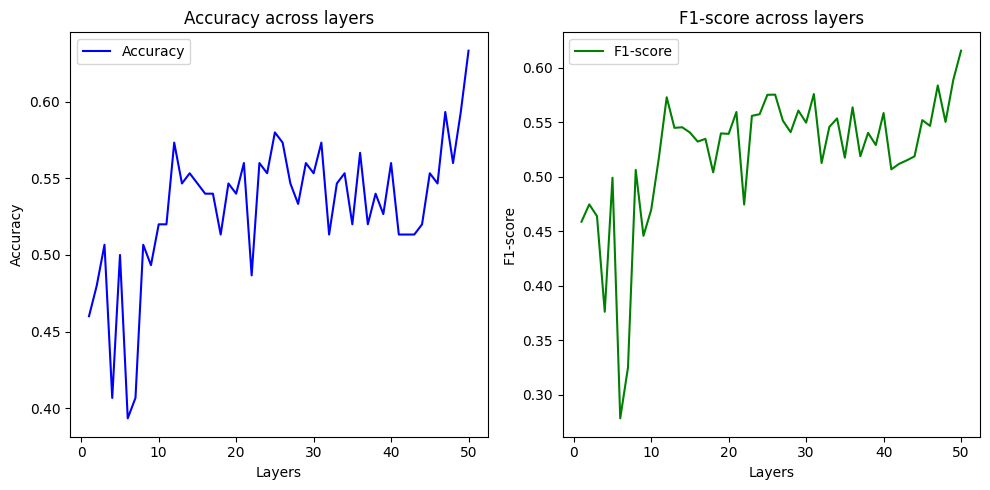

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = wespeaker.load_model_local('/content/extracted_files/voxblink2_samresnet34')
model.set_device(device)

# train_audio = df_train['audio_path'].to_list()
# train_labels = df_train['class'].to_list()

# test_audio = df_test['audio_path'].to_list()
# test_labels = df_test['class'].to_list()

acts_model = GetActivations(model)
acts = get_activations(acts_model, train_audio[0], device)
layers = [list(item.keys())[0] for item in acts['act']]

metrics_list = []

for layer in layers:
    train_acts, train_labels = get_activations_for_layer(
        acts_model, train_audio, device, layer, train_labels)
    test_acts, test_labels = get_activations_for_layer(
        acts_model, test_audio, device, layer, test_labels)

    train_dataset = ActivationDataset(train_acts, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    test_dataset = ActivationDataset(test_acts, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    trained_model = train(
        train_loader, train_dataset.X.shape[-1], layer, device)
    torch.save(trained_model.state_dict(),
                f"/content/models_tests/{layer}.pth")
    metrics = evaluate(trained_model, test_loader, device)

    metrics_list.append((layer, metrics))

    torch.cuda.empty_cache()

save_metrics(metrics_list, '/content/result/probing.txt')
plot_metrics(metrics_list, '/content/result/probing.png')

#Вывод
Обе метрики демонстрируют схожую динамику по мере увеличения глубины слоев.
При этом довольно странно видеть, как метрика сильно колеблется, возможно это связано из-за специфики слоев. Они разные, ведь мы рассматриваем разные ReLU и SimAM

Ранние слои (layer1) показывают низкие метрики, потому что они извлекают примитивные признаки.

Более глубокие слои (layer3-4) комбинируют признаки, что может улучшать результаты (но не всегда).

Pooling-слой даёт лучший результат (0.63), потому что агрегирует информацию, снижая переобучение.

Но как будто по итогу мы можем видеть, что модель обучается и выдает хорошую метрику, даже с учетом того, что сам датасет уменьшен в 2 раза. Думаю, что при большем объеме данных, мы получим метрики сильно лучше.